In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

In [6]:
true_capacity, pred_capacity = np.load("capacity.npy"), np.load("capacity_pred.npy")

print(true_capacity.shape, pred_capacity.shape)

(152,) (152,)


In [15]:
THRESHOLD = 0.83

In [9]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def poly_fit(x, y, order):
    coef = np.polyfit(x, y, order)
    poly = Polynomial(coef[::-1])  # np.polyfit的系数是从高次到低次，Polynomial需要从低次到高次
    return poly

In [10]:
def get_80pct_cycle(capacity):
    cnt = 0
    for i in range(len(capacity)):
        if capacity[i] / capacity[0] < THRESHOLD:
            if cnt == 0:
                target = i
            if cnt == 5:
                return target, capacity[target]
            cnt += 1
        else:
            cnt == 0
    raise ValueError("No 80% cycle found")

In [11]:
def plot_poly(poly, x, y):
    plt.figure()
    y_fit = poly(x)
    plt.plot(x, y, 'ro', label='Original data')
    plt.plot(x, y_fit, 'b-', label='Fitted curve')
    plt.plot(*get_80pct_cycle(y), 'go', label='80% capacity')
    plt.title('Battery Capacity Degradation')
    plt.xlabel('Cycle')
    plt.ylabel('Capacity (Ah)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
def plot_raw(true_capacity):
    cycle = np.arange(1, len(true_capacity) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(cycle, true_capacity, "b-", label="Original data", markersize=3)
    print(get_80pct_cycle(true_capacity))
    p_x, p_y = get_80pct_cycle(true_capacity)
    plt.plot(p_x, p_y, "ro", label="80% capacity")
    plt.plot(cycle, [p_y for _ in range(len(cycle))], "r--")
    plt.title("Battery Capacity Degradation", fontsize=18)
    plt.xlabel("Cycle", fontsize=16)
    plt.ylabel("Capacity (mAh)", fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

(135, 30.16254136219446)


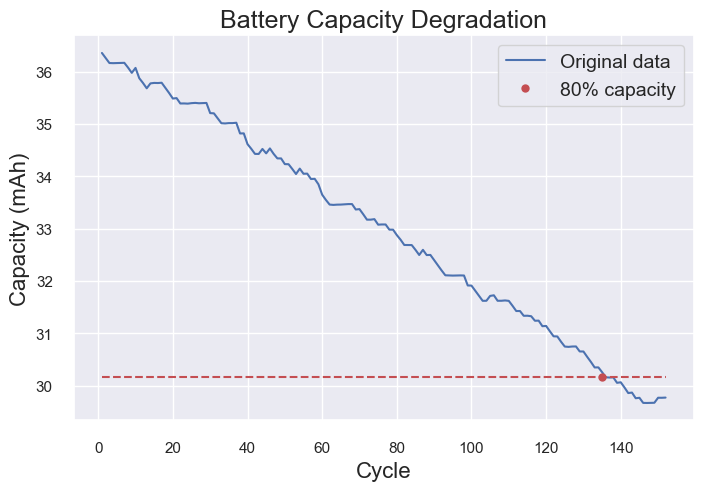

In [32]:
plot_raw(true_capacity)

模型评估


In [33]:
import numpy as np

# 计算MSE
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# 计算R²
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

In [34]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def fit_partial(y, l, r, order):
    y = y[l:r]
    x = np.arange(l, r)
    coef = np.polyfit(x, y, order)
    poly = Polynomial(coef[::-1])
    return poly

def pred_80pct_cycle(poly, initial_capacity):
    coef = poly.coef
    beta_0, beta_1 = coef
    return (THRESHOLD * initial_capacity - beta_0) / beta_1, THRESHOLD * initial_capacity

In [74]:
def plot_poly_pred(poly, x, y, cycle_l, cycle_r):
    plt.figure(figsize=(8, 5))
    y_fit = poly(x)
    plt.plot(x, y, 'bo', label='Original data', markersize=2)
    plt.plot(x, y_fit, 'g-', label='Fitted Curve')
    plt.plot(*get_80pct_cycle(y), 'bo', label='80% Capacity')
    plt.plot(*pred_80pct_cycle(poly, y[0]), 'go', label='Predicted 80% Capacity')
    
    plt.plot([cycle_l, cycle_l], [y[cycle_l]-1, y[cycle_l]+1], 'g--', label='Window Range')
    plt.plot([cycle_r, cycle_r], [y[cycle_r]-1, y[cycle_r]+1], 'g--')
    
    plt.title('Battery Capacity Degradation', fontsize=18)
    plt.xlabel('Cycle', fontsize=16)
    plt.ylabel('Capacity (mAh)', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [75]:
def plot_iteration_withTrueCapacity(capacity):
    l = 70
    r = 100
    ORDER = 1
    delta_l = 5
    
    cycle = np.arange(1, len(capacity) + 1)
    while r < len(capacity):
        poly = fit_partial(capacity, l, r, ORDER)
        print(f'Partial fit with ({l}, {r})')
        cycle_true, capa_true = get_80pct_cycle(capacity)
        cycle_pred, capa_pred = pred_80pct_cycle(poly, capacity[0])
        print(f'80% capacity: true: {cycle_true}, pred: {cycle_pred:.2f}')
        print(f"error: {abs(cycle_true-cycle_pred):.2f} cycle, relative error: {abs(cycle_true-cycle_pred)/cycle_true:.2%}")
        plot_poly_pred(poly, cycle, capacity, l, r)
        l += delta_l
        r += delta_l

Partial fit with (70, 100)
80% capacity: true: 135, pred: 134.85
error: 0.15 cycle, relative error: 0.11%


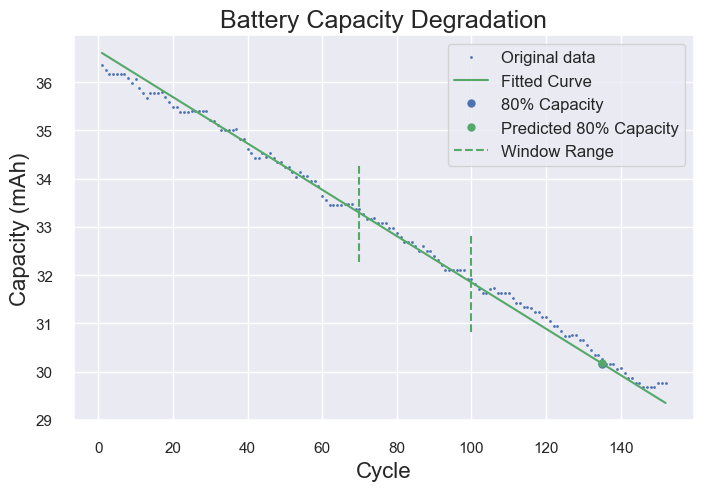

Partial fit with (75, 105)
80% capacity: true: 135, pred: 132.81
error: 2.19 cycle, relative error: 1.62%


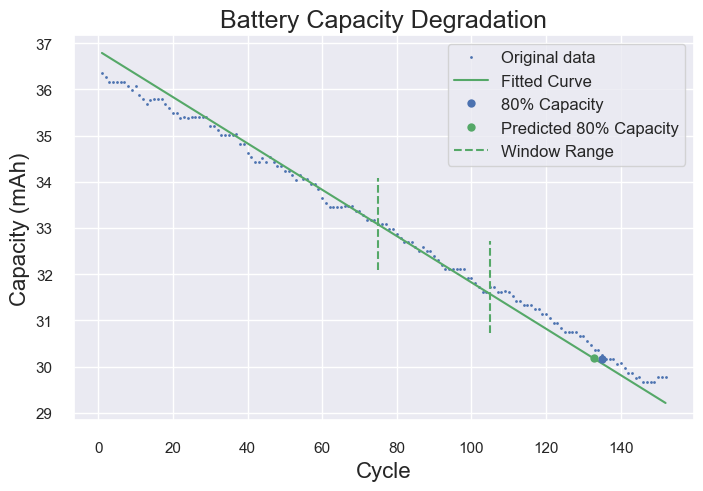

Partial fit with (80, 110)
80% capacity: true: 135, pred: 138.62
error: 3.62 cycle, relative error: 2.68%


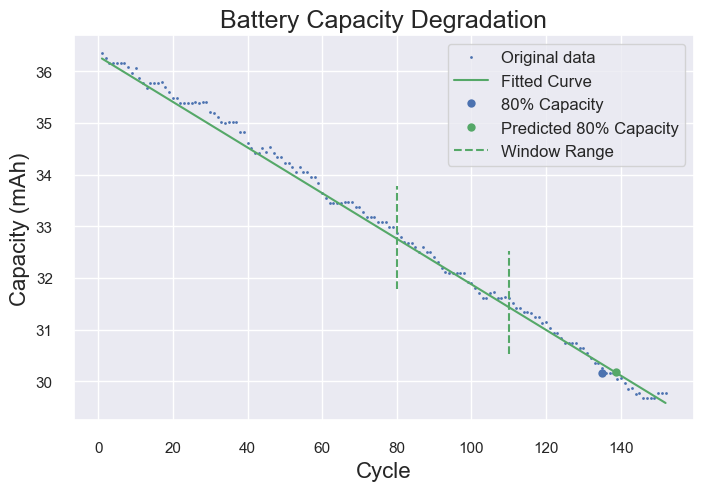

Partial fit with (85, 115)
80% capacity: true: 135, pred: 141.01
error: 6.01 cycle, relative error: 4.45%


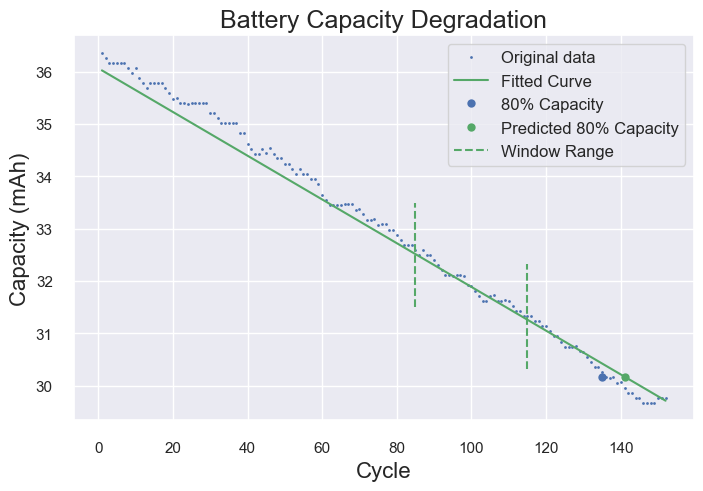

Partial fit with (90, 120)
80% capacity: true: 135, pred: 144.45
error: 9.45 cycle, relative error: 7.00%


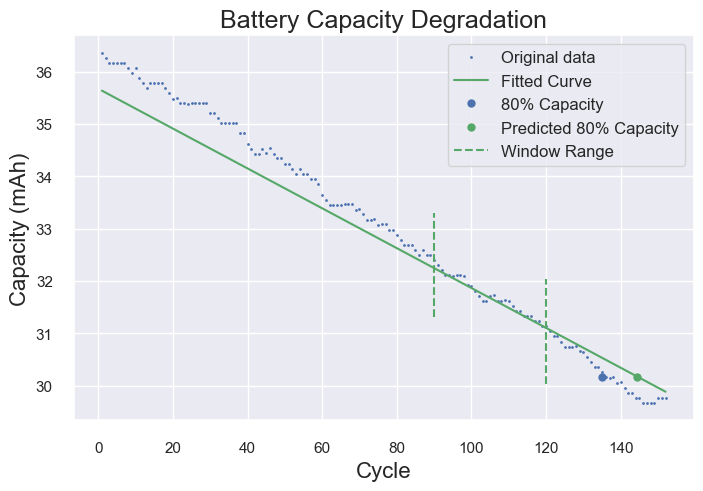

Partial fit with (95, 125)
80% capacity: true: 135, pred: 140.82
error: 5.82 cycle, relative error: 4.31%


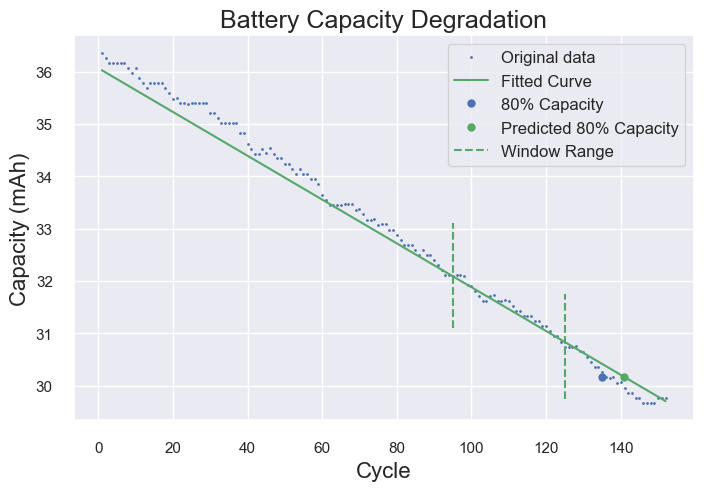

Partial fit with (100, 130)
80% capacity: true: 135, pred: 140.46
error: 5.46 cycle, relative error: 4.05%


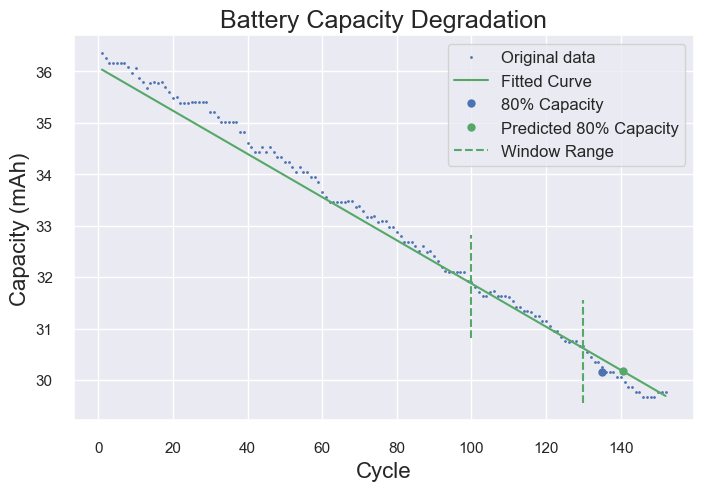

Partial fit with (105, 135)
80% capacity: true: 135, pred: 137.14
error: 2.14 cycle, relative error: 1.59%


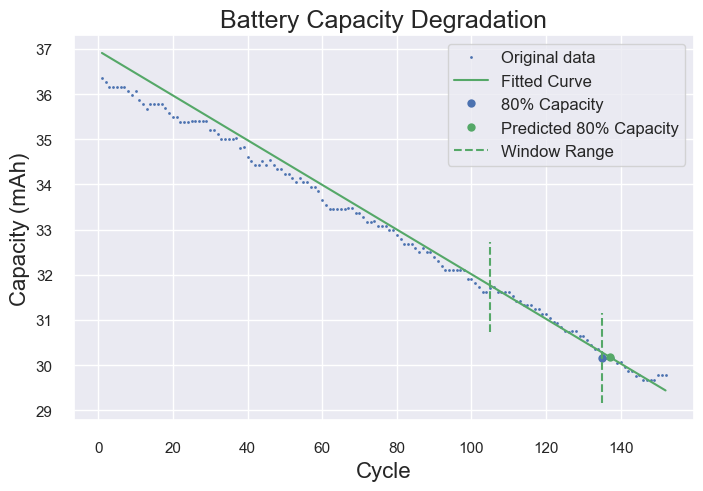

Partial fit with (110, 140)
80% capacity: true: 135, pred: 136.40
error: 1.40 cycle, relative error: 1.04%


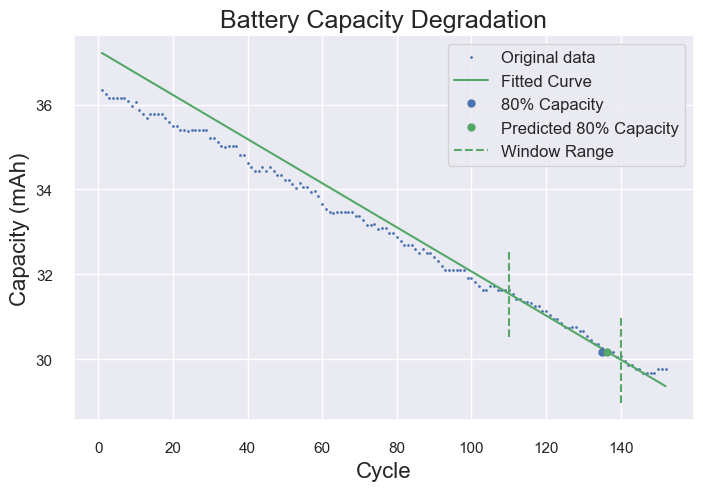

Partial fit with (115, 145)
80% capacity: true: 135, pred: 136.10
error: 1.10 cycle, relative error: 0.81%


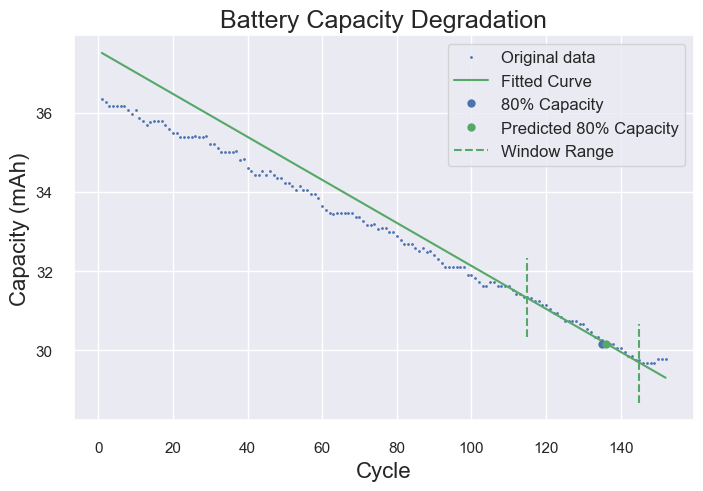

Partial fit with (120, 150)
80% capacity: true: 135, pred: 136.55
error: 1.55 cycle, relative error: 1.15%


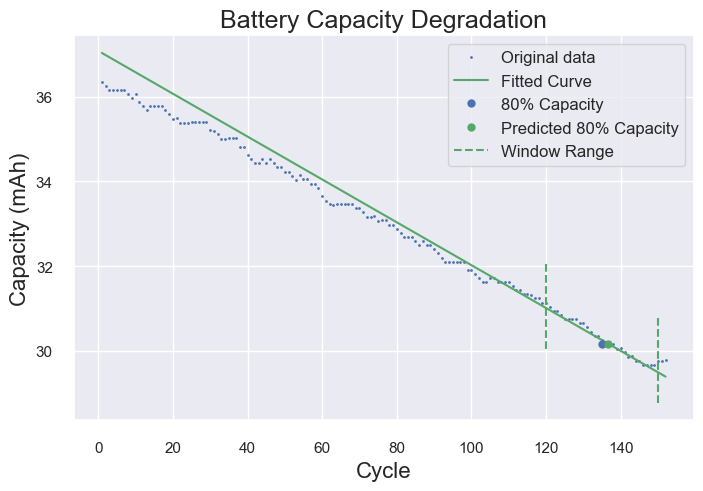

In [76]:
plot_iteration_withTrueCapacity(true_capacity)

In [ ]:
def plot_iteration_withPredCapacity(true_capacity, pred_capacity):
    l = 400
    r = 500
    ORDER = 1
    delta_l = 50
    
    cycle = np.arange(1, len(true_capacity) + 1)
    while r < len(true_capacity):
        poly = fit_partial(pred_capacity, l, r, ORDER)
        print(f'Partial fit with ({l}, {r})')
        idx_true, cycle_true = get_80pct_cycle(true_capacity)
        idx_pred, cycle_pred = pred_80pct_cycle(poly, true_capacity[0])
        print(f'80% capacity: true: {idx_true}, pred: {idx_pred}, diff: {abs(idx_true-idx_pred)}')
        plot_poly_pred(poly, cycle, true_capacity)
        l += delta_l
        r += delta_l

神经网络模型

In [42]:
import torch
from torch import nn

class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)  # 假设输入特征只有1维
        self.fc = nn.Linear(64, 1)  # 假设我们做的是回归任务
    
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (h_n, _) = self.lstm(x)
        x = h_n[-1, :, :]
        return self.fc(x)


In [43]:
from torch import optim

L = 0
R = 800

model = LSTMNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 假设你已经有了训练数据X_train和y_train
# 注意：在训练之前，你需要将数据转换为Tensor

X_train = torch.tensor(cycle[L:R]).float().unsqueeze(-1).unsqueeze(-1)  # 增加两个维度
# 现在X_train的形状应该是 [batch_size, seq_len, features]，其中seq_len=1, features=1
y_train = torch.tensor(capacity[L:R]).float().unsqueeze(-1)  # 确保y_train也有正确的维度


# 训练模型（示例）
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

NameError: name 'cycle' is not defined

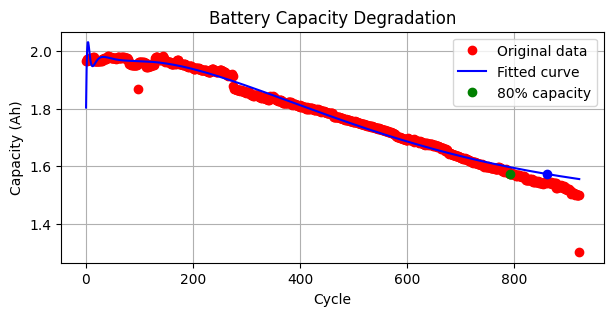

80% capacity cycle: 861, true: 791, diff: 70


In [39]:
y_pred = model(torch.tensor(cycle).float().unsqueeze(-1).unsqueeze(-1)).detach().numpy().flatten()
plt.figure(figsize=(7, 3))
plt.plot(cycle, capacity, 'ro', label='Original data')
plt.plot(cycle, y_pred, 'b-', label='Fitted curve')
plt.plot(*get_80pct_cycle(capacity), 'go', label='80% capacity')
for y in y_pred:
    if y < THRESHOLD * capacity[0]:
        plt.plot(cycle[y_pred == y], y_pred[y_pred == y], 'bo')
        target_cycle = cycle[y_pred == y][0]
        break
# plt.plot(*pred_80pct_cycle(poly, y[0]), 'bo', label='Predicted 80% capacity')
plt.title('Battery Capacity Degradation')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.show()

print(f'80% capacity cycle: {target_cycle}, true: {get_80pct_cycle(capacity)[0]}, diff: {abs(target_cycle-get_80pct_cycle(capacity)[0])}')